All the '.csv' source file names correspond to the equivalent names in the Voutsinos25_supplement_data_v01 file

# Validation tiles plotting (2A)

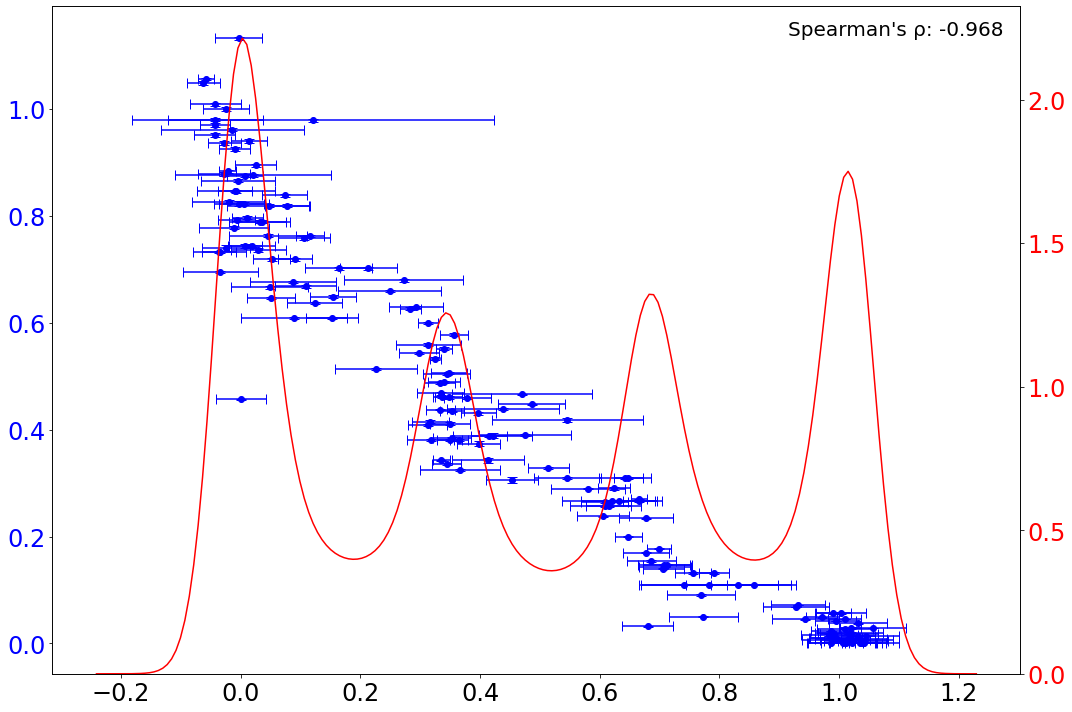

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Load the data
plotted_data = pd.read_csv("low-throughput.csv")
degrons_data = pd.read_csv("scores.csv")

# plot
fig, ax1 = plt.subplots(figsize=(15, 10))

# data
scatter_data = ax1.errorbar(plotted_data['score'], plotted_data['Adjusted Mean (GFP:mCherry)'], 
                            xerr=plotted_data['std'], yerr=plotted_data['Adjusted SE'], 
                            fmt='o', capsize=5, color='blue')

ax1.tick_params(axis='y', labelcolor='blue')

# Plot the density
ax2 = ax1.twinx()
sns.kdeplot(degrons_data['degron_score'], ax=ax2, color='red', legend=False)
ax2.set_ylabel('')  # Remove the 'Density' label

# primary y-axis
ax1.tick_params(axis='y', labelcolor='blue', labelsize=24)  

# x-axis
ax1.tick_params(axis='x', labelsize=24)  

# secondary y-axis
ax2.tick_params(axis='y', labelcolor='red', labelsize=24) 

# Calculate and print the Spearman correlation
spearman_corr, _ = spearmanr(plotted_data['score'], plotted_data['Adjusted Mean (GFP:mCherry)'])

ax1.text(0.76, 0.98, f"Spearman's ρ: {spearman_corr:.3f}", transform=ax1.transAxes, verticalalignment='top', size=20)

plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("validation_tiles_spearman.pdf")

plt.show()


# Average aa effect (2B)

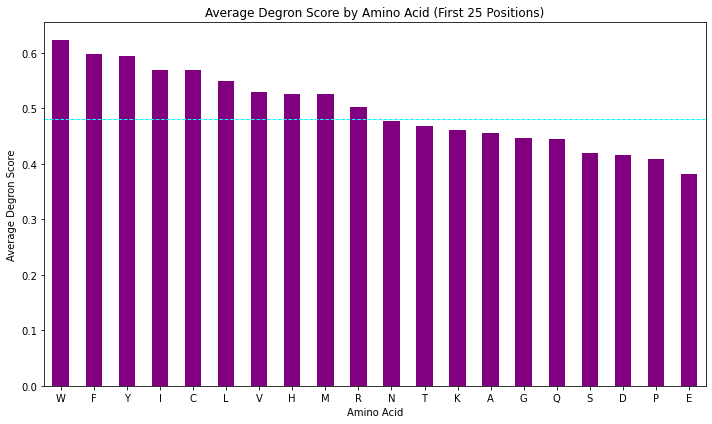

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv('scores.csv')

# Filter out sequences containing '*'
data = data[~data['aa'].str.contains('\*')]

# Initialize a dictionary
aamino_acid_scores = {}

# Loop through each position in the first 25 positions
for position in range(25):
    # Extract the amino acid at the current position for all sequences
    data[f'position_{position}'] = data['aa'].str[position]

# Flatten all amino acids into one column along with degron scores
flattened = []
for position in range(25):
    flattened.extend(zip(data[f'position_{position}'], data['degron_score']))

# Convert the flattened list into a DataFrame
flattened_df = pd.DataFrame(flattened, columns=['amino_acid', 'degron_score'])

# Calculate the mean degron score for each amino acid
average_scores = flattened_df.groupby('amino_acid')['degron_score'].mean()

# Plot
average_scores.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6),color='purple')

# Calculate the overall average degron score
overall_average = flattened_df['degron_score'].mean()

# Plot
total_positions = len(average_scores)
plt.axhline(y=overall_average, color='cyan', linestyle='--', linewidth=1, label=f'Overall Average: {overall_average:.2f}')

plt.title('Average Degron Score by Amino Acid (First 25 Positions)')
plt.xlabel('Amino Acid')
plt.ylabel('Average Degron Score')
plt.xticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig('average_degron_score_barplot.pdf')
plt.show()


# Average aa per position effects (heatmap) (2C)

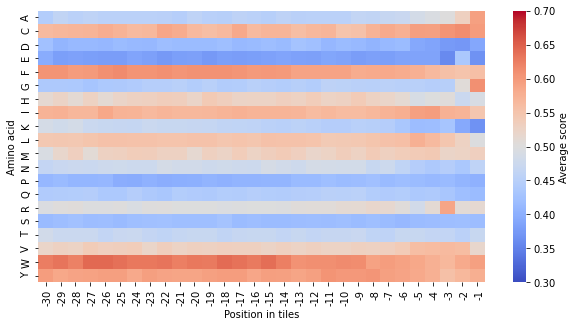

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.transforms as mtransforms

# Load the data
df = pd.read_csv('scores.csv')

# Filter out rows with sequences containing '*' or with length different from 30
filtered_out_df = df[(df['aa'].str.contains('\*')) | (df['aa'].str.len() != 30)]
filtered_out_df.to_csv('filtered_out_sequences.csv', index=False)

# Continue with only valid sequences
df = df[~(df['aa'].str.contains('\*')) & (df['aa'].str.len() == 30)]

aa_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Initialize dictionaries for each amino acid at each position
aa_dict = {pos: {aa: {'sum': 0, 'sum_square': 0, 'count': 0} for aa in aa_list} for pos in range(30)}

# Analyze the data
for _, row in df.iterrows():
    sequence = row['aa']
    score = row['degron_score']

    for pos, aa in enumerate(sequence):
        if aa in aa_dict[pos]:  
            aa_dict[pos][aa]['sum'] += score
            aa_dict[pos][aa]['sum_square'] += score**2
            aa_dict[pos][aa]['count'] += 1

# Compute averages, counts, and standard deviations
averages = {pos: {aa: aa_data['sum']/aa_data['count'] if aa_data['count'] != 0 else 0 for aa, aa_data in pos_data.items()} for pos, pos_data in aa_dict.items()}
counts = {pos: {aa: aa_data['count'] for aa, aa_data in pos_data.items()} for pos, pos_data in aa_dict.items()}
std_devs = {pos: {aa: np.sqrt((aa_data['sum_square'] - (aa_data['sum']**2)/aa_data['count'])/aa_data['count']) if aa_data['count'] > 1 else 0 for aa, aa_data in pos_data.items()} for pos, pos_data in aa_dict.items()}

# Convert to DataFrame
averages_df = pd.DataFrame(averages)
counts_df = pd.DataFrame(counts)
std_devs_df = pd.DataFrame(std_devs)

# Change column names to range from -30 to -1
new_columns = range(-30, 0)
averages_df.columns = counts_df.columns = std_devs_df.columns = new_columns

# Plot heatmap
plt.figure(figsize=(10, 5))
ax = sns.heatmap(averages_df, cmap="coolwarm", vmin=0.3, vmax=0.7, cbar_kws={'label': 'Average score'})
plt.ylabel('Amino acid')
plt.xlabel('Position in tiles')

# Adjust the position of the x-axis labels
ax.set_xticks(np.arange(0.5, len(new_columns), 1))  # Setting ticks at the middle of each cell
ax.set_xticklabels(new_columns, ha='left')  # Align labels to the left of the tick mark

# Adjust label positions
for label in ax.get_xticklabels():

    offset = mtransforms.ScaledTranslation(-0.04, 0, plt.gcf().dpi_scale_trans)
    label.set_transform(label.get_transform() + offset)

# Save the figure
plt.savefig("heatmap4.pdf", format='pdf')
plt.show()

# Save DataFrames to csv
averages_df.to_csv('averages_heatmap4.csv', index=True)
counts_df.to_csv('counts_heatmap4.csv', index=True)
std_devs_df.to_csv('std_devs_heatmap4.csv', index=True)

# C-degron effects

### C-degron effects (significance)

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Load data
data = pd.read_csv('scores.csv')
data = data[data['aa'].astype(str).str.contains(r'\*', regex=True, na=False) == False]
data = data[data['aa'].str.len() == 30]

# Define amino acids and positions
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
positions = range(30)  # Positions 0 to 29, labeled as -30 to -1

# Initialize results dictionaries
counts = {aa: [0]*30 for aa in amino_acids}
counts_not_pos = {aa: [0]*30 for aa in amino_acids}
average_scores = {aa: [0]*30 for aa in amino_acids}
average_scores_not_pos = {aa: [0]*30 for aa in amino_acids}
sd_scores = {aa: [0]*30 for aa in amino_acids}
sd_scores_not_pos = {aa: [0]*30 for aa in amino_acids}
p_values = {aa: [1]*30 for aa in amino_acids}
significant_results = {aa: [np.nan]*30 for aa in amino_acids}

# Analysis loop
for aa in amino_acids:
    for pos in positions:
        # Filter data
        data_pos = data[data['aa'].apply(lambda seq: seq[pos] == aa and seq.count(aa) == 1)]
        data_not_pos = data[data['aa'].apply(lambda seq: seq[pos] != aa and seq.count(aa) == 1)]

        # Calculate statistics
        counts[aa][pos] = len(data_pos)
        counts_not_pos[aa][pos] = len(data_not_pos)
        
        if not data_pos.empty:
            average_scores[aa][pos] = data_pos['degron_score'].mean()
            sd_scores[aa][pos] = data_pos['degron_score'].std()
        
        if not data_not_pos.empty:
            average_scores_not_pos[aa][pos] = data_not_pos['degron_score'].mean()
            sd_scores_not_pos[aa][pos] = data_not_pos['degron_score'].std()
        
        # Mann-Whitney U Test
        if not data_pos.empty and not data_not_pos.empty:
            _, p_value = mannwhitneyu(data_pos['degron_score'], data_not_pos['degron_score'], alternative='two-sided')
            p_values[aa][pos] = p_value
            # Bonferroni correction: adjust alpha level by the number of tests (30 per amino acid)
            if p_value < (0.05 / 600):
                significant_results[aa][pos] = p_value

# Transform dictionaries into DataFrames and transpose
position_labels = list(range(-30, 0))
df_counts = pd.DataFrame(counts, index=position_labels).transpose()
df_counts_not_pos = pd.DataFrame(counts_not_pos, index=position_labels).transpose()
df_average_scores = pd.DataFrame(average_scores, index=position_labels).transpose()
df_average_scores_not_pos = pd.DataFrame(average_scores_not_pos, index=position_labels).transpose()
df_sd_scores = pd.DataFrame(sd_scores, index=position_labels).transpose()
df_sd_scores_not_pos = pd.DataFrame(sd_scores_not_pos, index=position_labels).transpose()  
df_p_values = pd.DataFrame(p_values, index=position_labels).transpose()
df_significant_results = pd.DataFrame(significant_results, index=position_labels).transpose()

# Save results to CSV

df_average_scores.to_csv('average_scores_aa_in_pos.csv')
df_average_scores_not_pos.to_csv('average_scores_aa_not_in_pos.csv')
df_significant_results.to_csv('significant_results.csv')



### C-degron effect heatmap (2D)

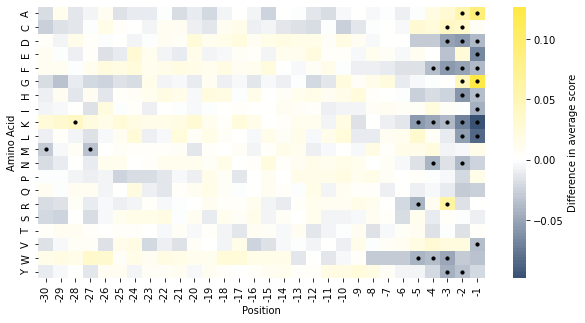

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load average scores from CSV files
df_average_scores_in_pos = pd.read_csv('average_scores_aa_in_pos.csv', index_col=0)
df_average_scores_not_in_pos = pd.read_csv('average_scores_aa_not_in_pos.csv', index_col=0)

# Subtract the two DataFrames
df_difference = df_average_scores_in_pos - df_average_scores_not_in_pos

# Save the difference to a new CSV file
df_difference.to_csv('difference_average_scores.csv')

# Load significant results
df_significant_results = pd.read_csv('significant_results.csv', index_col=0)

# Create a mask for significant results to use in heatmap
mask = df_significant_results.notna()

# Custom colormap
colors = ["#00204C", "white", "#FFE945"]  
n_bins = 100  
cmap_name = 'custom_cividis_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Plot heatmap of the differences
plt.figure(figsize=(10, 5))
sns.heatmap(df_difference, cmap=custom_cmap, center=0,
            cbar_kws={'label': 'Difference in average score'},
            annot=False)  # No annotation of values

# Overlay dots on significant cells
for y in range(df_difference.shape[0]):
    for x in range(df_difference.shape[1]):
        if mask.iloc[y, x]:  # Check if position is significant
            plt.scatter(x + 0.5, y + 0.5, color='black', s=10)  # Mark with black dot

plt.xlabel('Position')
plt.ylabel('Amino Acid')
plt.xticks(ticks=np.arange(0.5, len(df_difference.columns), 1), labels=df_difference.columns, rotation=90)
plt.yticks(ticks=np.arange(0.5, len(df_difference.index), 1), labels=df_difference.index)
plt.savefig('difference_in_vs_not_in_heatmap_v3.pdf', format='pdf')
plt.show()
plt.close()


# Correlation of degron scores with rASA (3A)

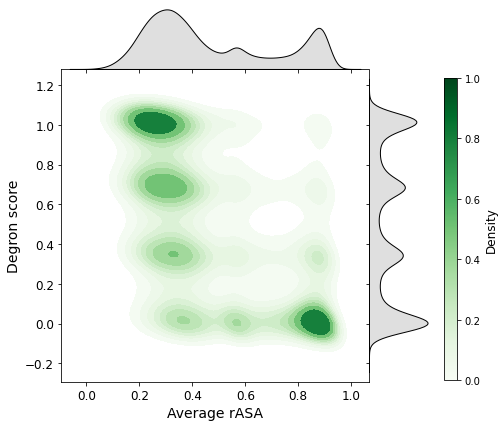

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
df = pd.read_csv('cytosol_proteome.csv')
df.dropna(subset=['rasa_average', 'degron_score'], inplace=True)

# Create a joint plot with specific color settings for the marginal histograms
joint = sns.jointplot(
    data=df,
    x='rasa_average',
    y='degron_score',
    kind="kde",
    fill=True,
    cmap="Greens",
    marginal_kws={'edgecolor': 'black', 'color': 'grey'},  # Set marginal histogram colors
    space=0,
    marginal_ticks=True
)

# Set axis labels and tick sizes
joint.set_axis_labels('Average rASA', 'Degron score', fontsize=14)
joint.ax_joint.tick_params(labelsize=12)

# Customize the marginal histograms
# Hide y-axis for the x-axis marginal histogram
joint.ax_marg_x.tick_params(axis='y', labelleft=False, left=False)  # Hide y-ticks and labels
joint.ax_marg_x.spines['left'].set_visible(False)  # Hide left spine

# Hide y-axis for the y-axis marginal histogram
joint.ax_marg_y.tick_params(axis='x', labelbottom=False, bottom=False)  # Hide x-ticks and labels
joint.ax_marg_y.spines['bottom'].set_visible(False)  # Hide bottom spine

# Add color bar for density
cax = joint.fig.add_axes([1, 0.1, 0.03, 0.7])  # Position of color bar
norm = plt.Normalize(vmin=joint.ax_joint.collections[0].get_clim()[0], vmax=joint.ax_joint.collections[0].get_clim()[1])
sm = plt.cm.ScalarMappable(cmap="Greens", norm=norm)
sm.set_array([])
cbar = joint.fig.colorbar(sm, cax=cax)
cbar.set_label('Density', fontsize=12)

# Save and display the plot
plt.savefig('average_rASA_vs_score_jointplot_new_colorbar.pdf', bbox_inches='tight')
plt.show()

# Correlation of degron scores with pLDDT (3B)

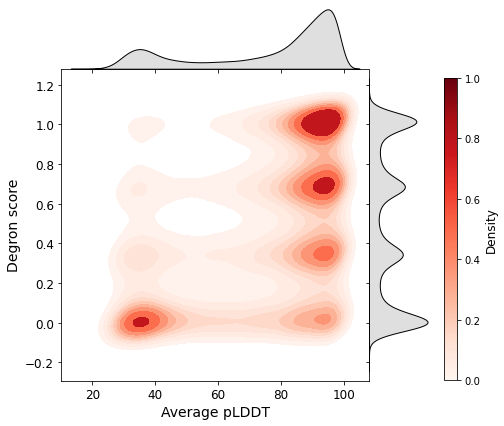

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
df = pd.read_csv('cytosol_proteome.csv')
df.dropna(subset=['plddt_average', 'degron_score'], inplace=True)

# Create a joint plot with specific color settings for the marginal histograms
joint = sns.jointplot(
    data=df,
    x='plddt_average',
    y='degron_score',
    kind="kde",
    fill=True,
    cmap="Reds",
    marginal_kws={'edgecolor': 'black', 'color': 'grey'},  # Set marginal histogram colors
    space=0,
    marginal_ticks=True
)

# Set axis labels and tick sizes
joint.set_axis_labels('Average pLDDT', 'Degron score', fontsize=14)
joint.ax_joint.tick_params(labelsize=12)

# Customize the marginal histograms
# Hide y-axis for the x-axis marginal histogram
joint.ax_marg_x.tick_params(axis='y', labelleft=False, left=False)  # Hide y-ticks and labels
joint.ax_marg_x.spines['left'].set_visible(False)  # Hide left spine

# Hide y-axis for the y-axis marginal histogram
joint.ax_marg_y.tick_params(axis='x', labelbottom=False, bottom=False)  # Hide x-ticks and labels
joint.ax_marg_y.spines['bottom'].set_visible(False)  # Hide bottom spine

# Add color bar for density
cax = joint.fig.add_axes([1, 0.1, 0.03, 0.7])  # Position of color bar
norm = plt.Normalize(vmin=joint.ax_joint.collections[0].get_clim()[0], vmax=joint.ax_joint.collections[0].get_clim()[1])
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
cbar = joint.fig.colorbar(sm, cax=cax)
cbar.set_label('Density', fontsize=12)

# Save and display the plot
plt.savefig('average_plddt_vs_score_jointplot_new_colorbar.pdf', bbox_inches='tight')
plt.show()

# Correlation between average tile degron score and PSI of proteins with average rASA above 0.7 (3C)

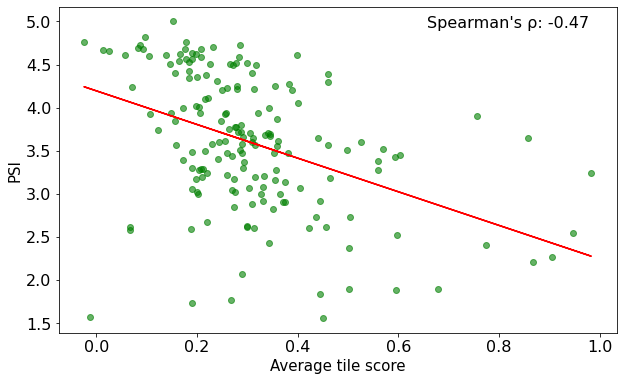

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import requests
import re

# Define a function to get gene name and protein description from UniProt
def get_uniprot_info(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.txt"
    response = requests.get(url)
    gene_name, protein_description = None, None
    
    if response.status_code != 200:
        return gene_name, protein_description
    
    for line in response.text.split("\n"):
        try:
            if line.startswith("GN"):
                gene_name = line.split("Name=")[1].split(";")[0]
            elif line.startswith("DE   RecName: Full="):
                protein_description = re.search("Full=(.*?);", line).group(1)
        except IndexError:
            pass
    
    return gene_name, protein_description

# Load the data from the CSV files
df1 = pd.read_csv('cytosol_proteome.csv')
df2 = pd.read_csv('merged_ORFome_final.csv')

df1 = df1.dropna(subset=['plddt_average', 'rasa_average'])

# Ensure all UniProt values in the list from df1['uniprot'] are checked against df2['uniprot']
if 'uniprot' in df1.columns and 'uniprot' in df2.columns:
    df1['uniprot'] = df1['uniprot'].apply(
        lambda x: [val.strip() for val in re.findall(r'\w+', x)] if isinstance(x, str) else []
    )
    # Explode the lists into individual rows
    df1 = df1.explode('uniprot')
    matching_rows = df1['uniprot'].isin(df2['uniprot'])
    df1 = df1[matching_rows]


if 'degron_score' in df1.columns and 'PSI' in df2.columns:
    avg_values = df1.groupby('uniprot')[['degron_score', 'plddt_average', 'rasa_average']].mean()
    psi_values = df2.groupby('uniprot')['PSI'].mean()
    merged = pd.merge(avg_values, psi_values, left_index=True, right_index=True)
    merged = merged.dropna(subset=['degron_score', 'PSI', 'plddt_average', 'rasa_average'])
    merged = merged[merged['rasa_average'] > 0.7]

    detailed_info_list = []
    for name in sorted(merged.index):
        gene_name, protein_description = get_uniprot_info(name)
        
        uniprot_rows = df1[df1['uniprot'] == name]
        
        for _, row in uniprot_rows.iterrows():
            detailed_info = row.to_dict()
            detailed_info.update({
                "Gene Name": gene_name,
                "Protein Description": protein_description,
                "Aggregate score": avg_values.loc[name, 'degron_score'],
                "Aggregate PLDDT Average": avg_values.loc[name, 'plddt_average'],
                "Aggregate RASA Average": avg_values.loc[name, 'rasa_average'],
                "PSI": psi_values.loc[name]})
            detailed_info_list.append(detailed_info)
    detailed_info_df = pd.DataFrame(detailed_info_list)
    detailed_info_df.to_csv('detailed_protein_info_all_final.csv', index=False)

    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(merged['degron_score'], merged['PSI'], color='green', alpha=0.6)

    z = np.polyfit(merged['degron_score'], merged['PSI'], 1)
    p = np.poly1d(z)
    plt.plot(merged['degron_score'], p(merged['degron_score']), "r-")

    r2 = r2_score(merged['PSI'], p(merged['degron_score']))
    spearman_corr, _ = spearmanr(merged['degron_score'], merged['PSI'])

    plt.xlabel('Average tile score', fontsize=15)
    plt.ylabel('PSI', fontsize=15)

    
    plt.tick_params(axis='both', which='major', labelsize=16)

    # Disable grid
    plt.grid(False)

    # Add Spearman correlation coefficient
    plt.text(0.95, 0.95, f"Spearman's ρ: {spearman_corr:.2f}", horizontalalignment='right',
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=16)

    plt.savefig('scatter_plot_ORF_PSI_vs_avg_score_details_all_final.pdf', format='pdf') 
    plt.show()

# Calculation of correlation significance of PAP score vs abundance scores in VAMP-seq proteins and plotting of VAMP-seq protein correlation maps

In [22]:
import numpy as np
import pandas as pd
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

df_all = pd.read_csv('vamp_seq_pap_correlation.csv',
            index_col='aa')

### Calculate Pearson r and p-values

In [23]:
dict_pearsonr = {}

for prot in df_all['prot'].dropna().unique():
    dict_pearsonr[prot] = {'i': [], 'r': [], 'p': [], 'n': []}
    df_prot = df_all.query(f'prot == "{prot}"')
    for i in df_prot['central_resi']:
        x = df_prot.query(f'{i-2:d}<=central_resi<={i+2:d}')['DeltaPAP']
        y = df_prot.query(f'{i-2:d}<=central_resi<={i+2:d}')['abundance_score']
        
        # Create a mask where neither x nor y is NaN or inf
        valid_mask = ~(np.isnan(x) | np.isinf(x) | np.isnan(y) | np.isinf(y))
        
        # Apply the mask to both x and y
        clean_x = x[valid_mask]
        clean_y = y[valid_mask]
        
        if len(clean_x) > 1 and len(clean_y) > 1:
            r, p = stats.pearsonr(clean_x, clean_y)
            n = len(clean_x)  # Count of data points
            dict_pearsonr[prot]['i'].append(i)
            dict_pearsonr[prot]['r'].append(r)
            dict_pearsonr[prot]['p'].append(p)
            dict_pearsonr[prot]['n'].append(n)

# Save the dictionary for later use
with open('p_values_5_pap_30.pkl', 'wb') as f:
    pickle.dump(dict_pearsonr, f)

### Load data for all the proteins

In [24]:
with open('p_values_5_pap_30.pkl', 'rb') as f:
    dict_pearsonr = pickle.load(f)

### Save CSV files

In [25]:
for prot in dict_pearsonr.keys():
    df = pd.DataFrame(index=dict_pearsonr[prot]['i'],columns=['r','p','rASA','threshold'])
    df['n'] = dict_pearsonr[prot]['n']
    df['r'] = dict_pearsonr[prot]['r']
    df['p'] = dict_pearsonr[prot]['p']
    df['rASA'] = df_all.query(f'prot == "{prot:s}"').rASA.values
    df['threshold'] = 0.05/len(dict_pearsonr[prot]['i'])
    df['Mut'] = df_all.query(f'prot == "{prot:s}"').variant.values
    df['delta_PAP'] = df_all.query(f'prot == "{prot:s}"').DeltaPAP.values
    df['abundance_score'] = df_all.query(f'prot == "{prot:s}"').abundance_score.values
    df['scaled_pLDDT'] = df_all.query(f'prot == "{prot:s}"').scaled_pLDDT.values
    df['rASA'] = df_all.query(f'prot == "{prot:s}"').rASA.values
    df.to_csv(f'complete_p_values_{prot:s}_5_pap_30.csv')

### Calculation of rASA and pLDDT averages

In [26]:
import os

def calculate_averages(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure the position column is sorted and has no name
    df = df.sort_values(by=df.columns[0]).reset_index(drop=True)
    position_col = df.columns[0]  # Assuming the first column is the position

    # Initialize new columns with NaN
    df['rASA_average'] = np.nan
    df['scaled_pLDDT_average'] = np.nan

    # Iterate through the DataFrame to calculate averages for an extended range of 5 positions
    for i in df.index:
        # Define the range of positions to include in the calculation
        positions = range(df[position_col][i] - 2, df[position_col][i] + 3)
        # Select rows that match the position range and drop duplicates to ensure unique position numbers
        valid_rows = df[df[position_col].isin(positions)].drop_duplicates(subset=position_col)

        # Calculate and assign averages, if valid rows exist
        if not valid_rows.empty:
            df.at[i, 'rASA_average'] = valid_rows['rASA'].mean().round(2)
            df.at[i, 'scaled_pLDDT_average'] = valid_rows['scaled_pLDDT'].mean().round(2)

    # Save the new CSV
    new_file_path = file_path.replace('.csv', '_rasa_plddt_avg.csv')
    df.to_csv(new_file_path, index=False)
    print(f"Processed and saved: {new_file_path}")

def main():
    # List of your protein names - replace these with your actual protein names
    proteins = ['ASPA', 'CYP2C19', 'CYP2C9', 'NUDT15', 'PRKN', 'PTEN', 'TPMT', 'VKOR']
    for protein in proteins:
        file_name = f'complete_p_values_{protein}_5_pap_30.csv'
        if os.path.exists(file_name):
            calculate_averages(file_name)
        else:
            print(f"File not found: {file_name}")

if __name__ == "__main__":
    main()


Processed and saved: complete_p_values_ASPA_5_pap_30_rasa_plddt_avg.csv
Processed and saved: complete_p_values_CYP2C19_5_pap_30_rasa_plddt_avg.csv
Processed and saved: complete_p_values_CYP2C9_5_pap_30_rasa_plddt_avg.csv
Processed and saved: complete_p_values_NUDT15_5_pap_30_rasa_plddt_avg.csv
Processed and saved: complete_p_values_PRKN_5_pap_30_rasa_plddt_avg.csv
Processed and saved: complete_p_values_PTEN_5_pap_30_rasa_plddt_avg.csv
Processed and saved: complete_p_values_TPMT_5_pap_30_rasa_plddt_avg.csv
Processed and saved: complete_p_values_VKOR_5_pap_30_rasa_plddt_avg.csv


### Plotting of VAMP-seq protein correlation maps (5 and S17)

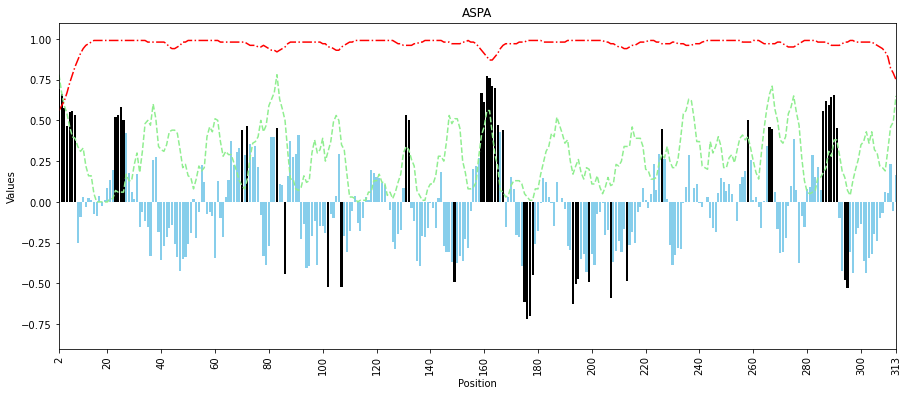

Plot saved for ASPA


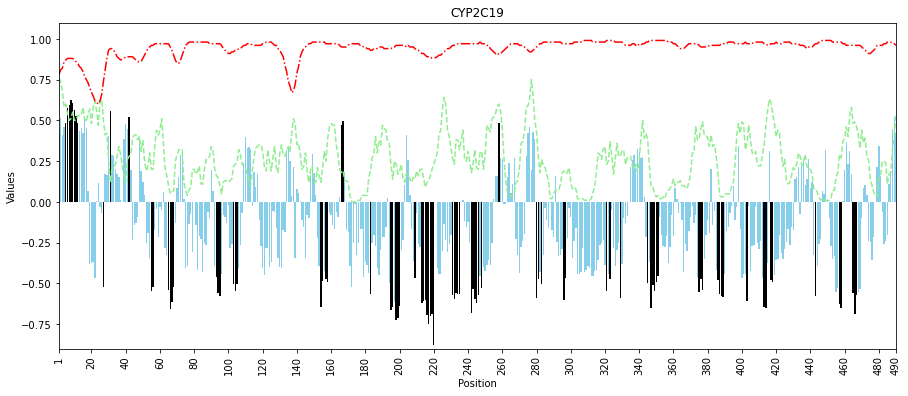

Plot saved for CYP2C19


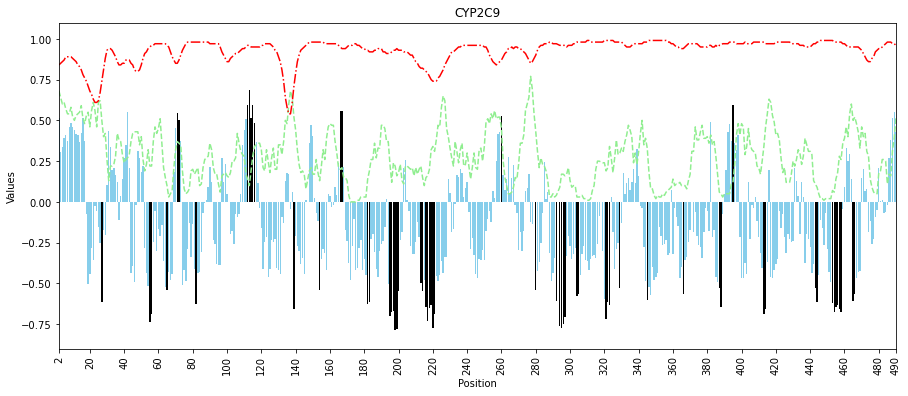

Plot saved for CYP2C9


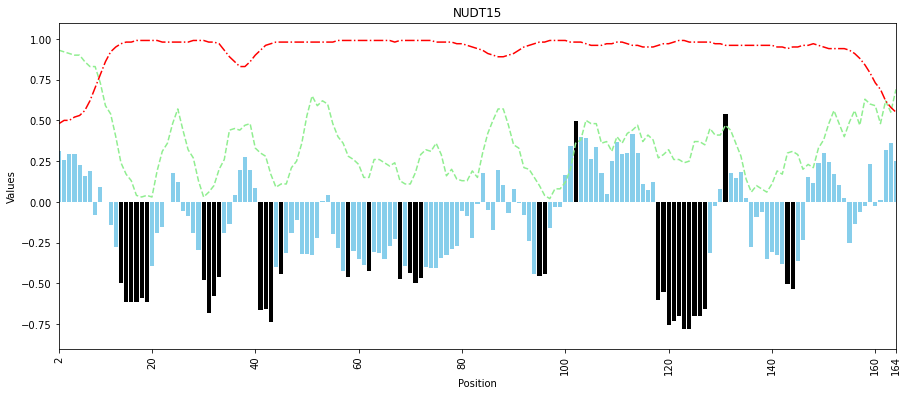

Plot saved for NUDT15


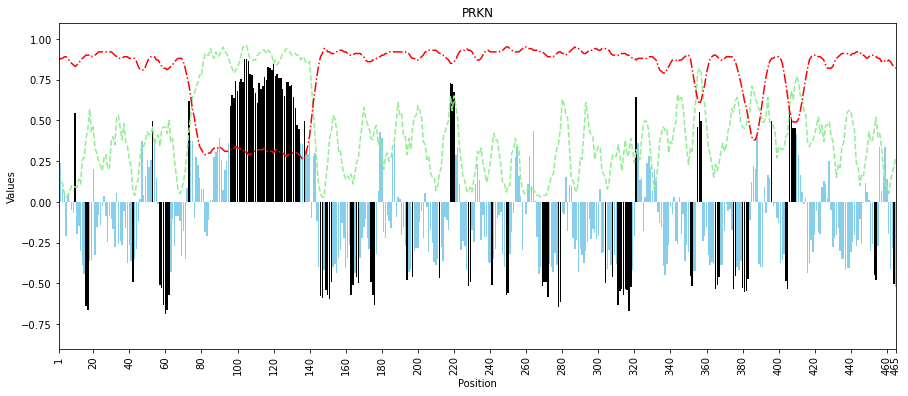

Plot saved for PRKN


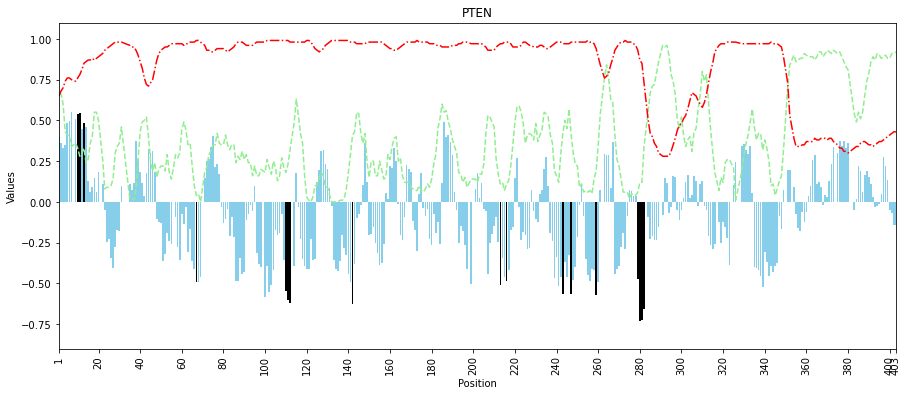

Plot saved for PTEN


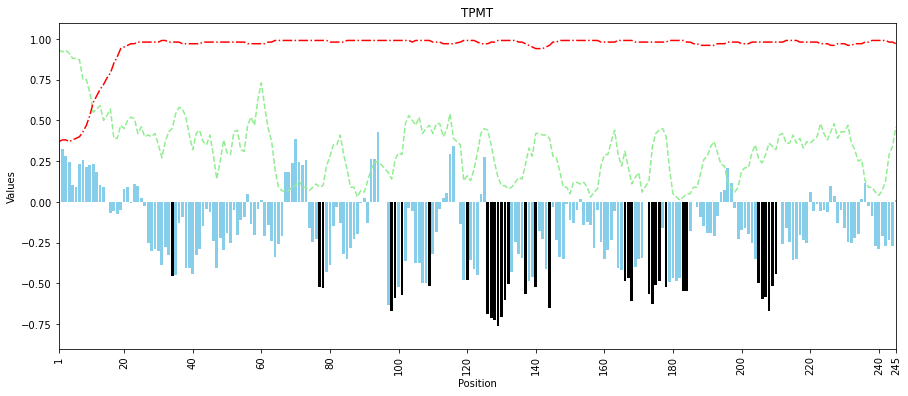

Plot saved for TPMT


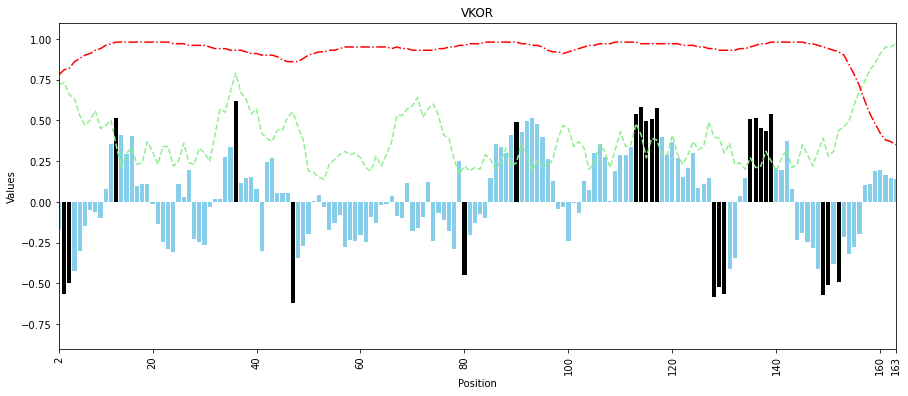

Plot saved for VKOR


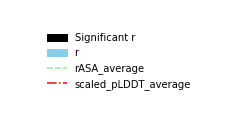

Legend saved as legend_only.pdf


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np

def plot_data(file_path, legend_handles):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))

    # Determine bar colors based on significance
    colors = ['black' if (row['p'] < row['threshold']) else 'skyblue' for index, row in df.iterrows()]

    # Bar plot for 'r' with conditional coloring
    bars = ax.bar(df[df.columns[0]], df['r'], color=colors)

    # Line plots for 'rASA_average' and 'scaled_pLDDT_average'
    ax.plot(df[df.columns[0]], df['rASA_average'], label='rASA_average', linestyle='--', color='lightgreen')
    ax.plot(df[df.columns[0]], df['scaled_pLDDT_average'], label='scaled_pLDDT_average', linestyle='-.', color='red')

    ax.set_ylim(-0.9, 1.1)
    ax.set_xlabel('Position')
    ax.set_ylabel('Values')

    # Calculate the actual first position and max position
    first_position = df[df.columns[0]].min()
    max_position = df[df.columns[0]].max()

    # Generate intermediate ticks
    tick_step = 20 
    intermediate_ticks = np.arange(np.ceil(first_position / tick_step) * tick_step, 
                                   np.floor(max_position / tick_step) * tick_step + 1, 
                                   tick_step)

    # Combine first and last positions with intermediate ticks
    xticks = np.unique(np.concatenate(([first_position], intermediate_ticks, [max_position])))
    
    ax.set_xticks(xticks)
    ax.set_xlim(left=first_position, right=max_position)  # Set x-axis limits to actual data range

    # Set labels for the ticks
    xtick_labels = [str(int(tick)) for tick in xticks]
    ax.set_xticklabels(xtick_labels, rotation=90)

    # Add plot title
    protein_name = file_path.split('_')[3]
    plt.title(protein_name)

    # Show and save plot as PDF
    plt.savefig(f"complete_r_plot_{protein_name}_w_pos_5_pap_30_new.pdf")
    plt.show()
    
    plt.close()
    print(f"Plot saved for {protein_name}")

def create_legend_pdf():
    # Create the figure for legend
    fig, ax = plt.subplots(figsize=(4, 2))
    
    # Custom legend handles
    skyblue_patch = mpatches.Patch(color='skyblue', label='r')
    green_line = plt.Line2D([0], [0], color='lightgreen', linestyle='--', label='rASA_average')
    red_line = plt.Line2D([0], [0], color='red', linestyle='-.', label='scaled_pLDDT_average')
    black_patch = mpatches.Patch(color='black', label='Significant r')

    # Create legend outside of axes
    legend_handles = [black_patch, skyblue_patch, green_line, red_line]
    legend = plt.legend(handles=legend_handles, loc='center', frameon=False)

    ax.axis('off')  # Turn off axes for clean legend
    
    # Save the legend as a separate PDF
    fig.savefig("legend_only.pdf", bbox_inches='tight')
    plt.show()
    plt.close()
    print("Legend saved as legend_only.pdf")

def main():
    proteins = ['ASPA', 'CYP2C19', 'CYP2C9', 'NUDT15', 'PRKN', 'PTEN', 'TPMT', 'VKOR']
    legend_handles = None
    for protein in proteins:
        file_name = f'complete_p_values_{protein}_5_pap_30_rasa_plddt_avg.csv'
        if os.path.exists(file_name):
            plot_data(file_name, legend_handles)
        else:
            print(f"File not found: {file_name}")
    
    # Generate legend only after all plots
    create_legend_pdf()

if __name__ == "__main__":
    main()

# C-end dipeptide statistics and violin plots (S4)

Plot data with sequences saved.
Non-parametric analysis completed and report saved.


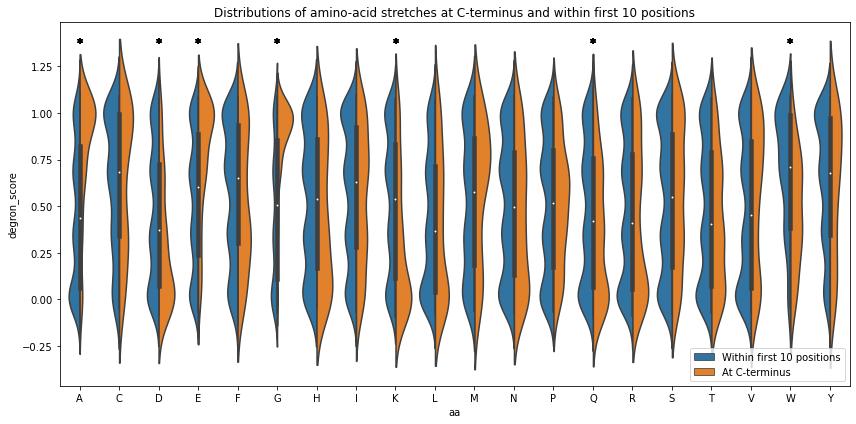

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from scipy.stats import mannwhitneyu

def find_modified_sequences(aa_series, score_series, condition, min_stretch, max_stretch=2):
    results = []
    for full_sequence, score in zip(aa_series, score_series):
        # Skip sequences containing an asterisk
        if '*' in full_sequence:
            continue
        
        if condition == 'last':
            last_part = full_sequence[-10:]
            unique_aas_in_last = set(last_part)
            for amino_acid in unique_aas_in_last:
                # Check if the amino acid appears only in the last part
                if full_sequence[:-10].count(amino_acid) == 0:
                    reversed_last_part = list(reversed(last_part))
                    for char, group in groupby(reversed_last_part):
                        if char == amino_acid:
                            stretch_length = len(list(group))
                            if (min_stretch <= stretch_length <= max_stretch and
                                last_part.endswith(amino_acid * stretch_length) and
                                last_part.count(amino_acid) == stretch_length):
                                results.append({
                                    'Full Sequence': full_sequence, 'aa': amino_acid,
                                    'degron_score': score, 'stretch': stretch_length})
                            break
        else:  # 'first' condition
            first_part = full_sequence[:10]
            unique_aas_in_first = set(first_part)
            for amino_acid in unique_aas_in_first:
                # Check if the amino acid appears only in the first part
                if full_sequence[10:].count(amino_acid) == 0:
                    for char, group in groupby(first_part):
                        if char == amino_acid:
                            stretch_length = len(list(group))
                            if (min_stretch <= stretch_length <= max_stretch and
                                first_part.count(amino_acid) == stretch_length):
                                results.append({
                                    'Full Sequence': full_sequence, 'aa': amino_acid,
                                    'degron_score': score, 'stretch': stretch_length})
                            break

    return pd.DataFrame(results)

# Load your data here
data = pd.read_csv('scores.csv')
min_stretch_size = 2

# Analyze sequences with the adjusted function
last_sequences = find_modified_sequences(data['aa'], data['degron_score'], 'last', min_stretch_size)
first_sequences = find_modified_sequences(data['aa'], data['degron_score'], 'first', min_stretch_size)

# Prepare and save the enhanced plot data
plot_data = pd.concat([
    last_sequences.assign(condition='At C-terminus'),
    first_sequences.assign(condition='Within first 10 positions')
])

plot_data.to_csv('plot_data_sequences_exclusive_dipeptide.csv', index=False)
print("Plot data with sequences saved.")

# Sort plot_data by amino acid in alphabetical order for plotting
plot_data_sorted = plot_data.sort_values(by='aa')

# Perform statistical tests and prepare the report
report_rows = []
unique_aas = sorted(plot_data_sorted['aa'].unique())
for aa in unique_aas:
    last_data = last_sequences[last_sequences['aa'] == aa]
    first_data = first_sequences[first_sequences['aa'] == aa]
    if not last_data.empty and not first_data.empty:
        u_stat, p_value = mannwhitneyu(last_data['degron_score'], first_data['degron_score'], alternative='two-sided')
        report_rows.append({
            'Amino Acid': aa,
            'Count - Last 10': len(last_data),
            'Average Score - Last 10': last_data['degron_score'].mean(),
            'SD - Last 10': last_data['degron_score'].std(),
            'Average Stretch - Last 10': last_data['stretch'].mean(),
            'Count - First 10': len(first_data),
            'Average Score - First 10': first_data['degron_score'].mean(),
            'SD - First 10': first_data['degron_score'].std(),
            'Average Stretch - First 10': first_data['stretch'].mean(),
            'Mann-Whitney U p-value': p_value
        })

report_df = pd.DataFrame(report_rows)
report_df.to_csv('nonparametric_analysis_report_exclusive_dipeptide.csv', index=False)
print("Non-parametric analysis completed and report saved.")

#Plotting with modifications for alphabetical order and stars
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='aa', y='degron_score', hue='condition', data=plot_data_sorted, split=True, order=sorted(plot_data_sorted['aa'].unique()))

# Add stars for significant differences
significant_aas = report_df[report_df['Mann-Whitney U p-value'] < 0.0025]['Amino Acid'].unique()
max_score = plot_data_sorted['degron_score'].max()
for aa in significant_aas:
    # Add stars for significant differences
    significant_aas = report_df[report_df['Mann-Whitney U p-value'] < 0.0025]['Amino Acid'].unique()
    max_score = plot_data_sorted['degron_score'].max()
    for aa in significant_aas:
        x_position = ax.get_xticks()[list(sorted(plot_data_sorted['aa'].unique())).index(aa)]
        plt.text(x_position, max_score * 1.20, '*', ha='center', fontsize=12, color='black', weight='bold')

plt.title('Distributions of amino-acid stretches at C-terminus and within first 10 positions')
# Move the legend to the bottom left
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots_exclusive_dipeptide.pdf')
plt.show()

# Poly-ala stretches (S5)

### Poly-ala within first 10 positions (S5A)

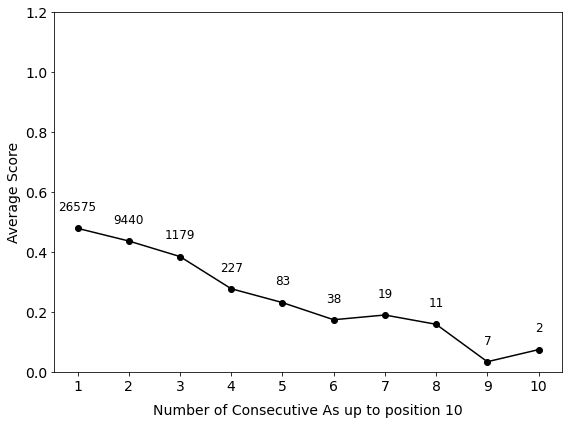

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the amino acids
amino_acids = ['A']

# Read CSV file
file_name = 'scores.csv'
data = pd.read_csv(file_name)

# Initialize a dictionary to store the sum of scores and the count of sequences for each pattern and each amino acid
aa_score_data = {aa: {f"{n}{aa}": {"score_sum": 0, "count": 0} for n in range(1, 11)} for aa in amino_acids}

# Iterate through the rows in the data to calculate the sum of scores and count of sequences for each pattern and each amino acid
for index, row in data.iterrows():
    sequence = row['aa']
    score = row['degron_score']

    for aa in amino_acids:
        for n in range(1, 11):
            pattern = aa * n
            if pattern in sequence and sequence.rfind(pattern) <= len(sequence) - len(pattern) - 20:
                aa_score_data[aa][f"{n}{aa}"]["score_sum"] += score
                aa_score_data[aa][f"{n}{aa}"]["count"] += 1

# Calculate the average score for each pattern and each amino acid
aa_average_scores = {
    aa: {
        pattern: (data["score_sum"] / data["count"] if data["count"] > 0 else None)
        for pattern, data in aa_score_data[aa].items()
    }
    for aa in amino_acids}

# Create a directory to save the plots and CSV files
output_dir = "Final_consecutive_As"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create a figure to hold all the plots
fig, axs = plt.subplots(nrows=len(amino_acids), ncols=1, figsize=(8, 6))

# Check if axs is a single AxesSubplot or an array
if len(amino_acids) == 1:
    axs = [axs]

# Save the data to CSV files and generate the plots for each amino acid
for i, aa in enumerate(amino_acids):
    # Save the data to a CSV file
    with open(f"{output_dir}/{aa}_consecutive_data_up_to_pos_10.csv", "w") as csvfile:
        csvfile.write("Pattern,Score Sum,Count,Average Score\n")
        for pattern, data in aa_score_data[aa].items():
            csvfile.write(f"{pattern},{data['score_sum']},{data['count']},{aa_average_scores[aa][pattern]}\n")

    # Get the patterns, scores, and counts
    patterns = list(aa_average_scores[aa].keys())
    scores = [aa_average_scores[aa][pattern] if aa_average_scores[aa][pattern] is not None else 0 for pattern in patterns]
    counts = [aa_score_data[aa][pattern]['count'] for pattern in patterns]

    # Plotting logic
    for j in range(len(patterns)):
        # Plot each point
        if counts[j] > 0:
            axs[i].plot(j, scores[j], marker='o', linestyle='', color='black')
        
        # Draw lines between consecutive points with valid scores
        if j < len(patterns) - 1 and counts[j] > 0 and counts[j + 1] > 0:
            axs[i].plot([j, j + 1], [scores[j], scores[j + 1]], linestyle='-', color='black')

    axs[i].set_xlabel(f"Number of Consecutive {aa}s up to position 10", fontsize=14, labelpad=10)
    axs[i].set_ylabel("Average Score", fontsize=14)
    axs[i].set_xticks(range(len(patterns))) 
    axs[i].set_xticklabels(range(1, len(patterns) + 1), fontsize=14)  
    axs[i].tick_params(axis='y', labelsize=14) 

    # Set the Y-axis limits
    axs[i].set_ylim(0, 1.2)

    # Add the count number above each point
    for j, score in enumerate(scores):
        count_text = f"{aa_score_data[aa][patterns[j]]['count']}" if score != 0 else "None"
        axs[i].text(j, score + 0.05, count_text, ha="center", va="bottom", fontsize=12)

# Save the figure as a PDF and display the plot
fig.tight_layout()
fig.savefig(f"{output_dir}/A_consecutive_plots_up_to_pos_10.pdf", format="pdf", dpi=300)
plt.show()

### Poly-ala at the C-terminus (S5B)

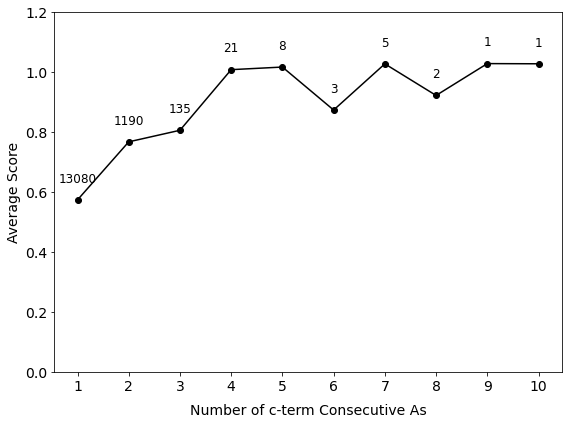

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the amino acids
amino_acids = ['A']

# Read CSV file
file_name = 'scores.csv'
data = pd.read_csv(file_name)

# Initialize a dictionary to store the sum of scores and the count of sequences for each pattern and each amino acid
aa_score_data = {aa: {f"{n}{aa}": {"score_sum": 0, "count": 0} for n in range(1, 11)} for aa in amino_acids}

# Iterate through the rows in the data to calculate the sum of scores and count of sequences for each pattern and each amino acid
for index, row in data.iterrows():
    sequence = row['aa']
    score = row['degron_score']

    for aa in amino_acids:
        for n in range(1, 11):
            pattern = aa * n
            next_pattern = aa * (n + 1)
            if sequence.endswith(pattern) and not sequence.endswith(next_pattern):
                aa_score_data[aa][f"{n}{aa}"]["score_sum"] += score
                aa_score_data[aa][f"{n}{aa}"]["count"] += 1

# Calculate the average score for each pattern and each amino acid
aa_average_scores = {
    aa: {
        pattern: (data["score_sum"] / data["count"] if data["count"] > 0 else None)
        for pattern, data in aa_score_data[aa].items()
    }
    for aa in amino_acids}

# Create a directory to save the plots and CSV files
output_dir = "Final_consecutive_As"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create a figure with a less wide aspect ratio
fig, axs = plt.subplots(nrows=len(amino_acids), ncols=1, figsize=(8, 6))

# Check if axs is a single AxesSubplot or an array
if len(amino_acids) == 1:
    axs = [axs]

# Save the data to CSV files and generate the plots for each amino acid
for i, aa in enumerate(amino_acids):
    # Save the data to a CSV file
    with open(f"{output_dir}/{aa}_consecutive_data_ctermonly.csv", "w") as csvfile:
        csvfile.write("Pattern,Score Sum,Count,Average Score\n")
        for pattern, data in aa_score_data[aa].items():
            csvfile.write(f"{pattern},{data['score_sum']},{data['count']},{aa_average_scores[aa][pattern]}\n")

    # Get the patterns, scores, and counts
    patterns = list(aa_average_scores[aa].keys())
    scores = [aa_average_scores[aa][pattern] if aa_average_scores[aa][pattern] is not None else 0 for pattern in patterns]
    counts = [aa_score_data[aa][pattern]['count'] for pattern in patterns]

    # Plotting logic
    for j in range(len(patterns)):
        # Plot each point
        if counts[j] > 0:
            axs[i].plot(j, scores[j], marker='o', linestyle='', color='black')
        
        # Draw lines between consecutive points with valid scores
        if j < len(patterns) - 1 and counts[j] > 0 and counts[j + 1] > 0:
            axs[i].plot([j, j + 1], [scores[j], scores[j + 1]], linestyle='-', color='black')

    axs[i].set_xlabel(f"Number of c-term Consecutive {aa}s", fontsize=14, labelpad=10)
    axs[i].set_ylabel("Average Score", fontsize=14)
    axs[i].set_xticks(range(len(patterns))) 
    axs[i].set_xticklabels(range(1, len(patterns) + 1), fontsize=14)  
    axs[i].tick_params(axis='y', labelsize=14)  

    # Adjust the Y-axis limits
    axs[i].set_ylim(0, 1.2) 

    # Add the count number above each point
    for j, score in enumerate(scores):
        count_text = f"{aa_score_data[aa][patterns[j]]['count']}" if score != 0 else "None"
        axs[i].text(j, score + 0.05, count_text, ha="center", va="bottom", fontsize=12)

# Save the figure as a PDF and display the plot
fig.tight_layout()
fig.savefig(f"{output_dir}/A_consecutive_plots_ctermonly_non_exclusive.pdf", format="pdf", dpi=300)
plt.show()

# Average degron score of all different aa-ending tiles (S6) 

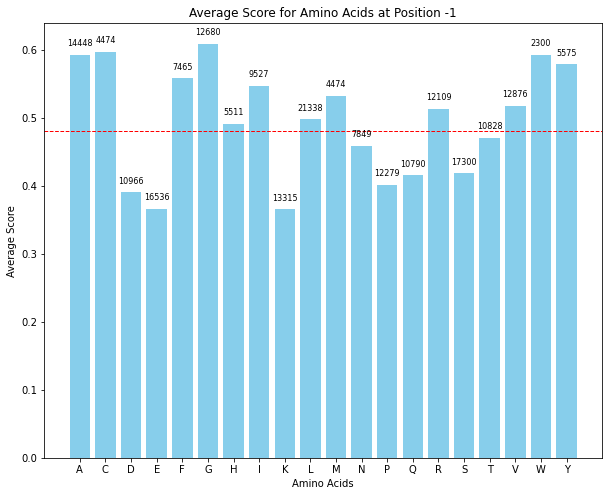

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('scores.csv')

# Function to check amino acid at a certain position
def check_amino_acid(row, position, amino_acid):
    try:
        return row['aa'][position] == amino_acid
    except:
        return False

# List of amino acids
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
position = -1 # Define the position, -1 for the final position

# Exclude sequences containing '*'
df = df[~df['aa'].str.contains('\*')]

# Dictionaries to store average scores and counts
average_scores = {}
counts = {}

# Iterate over amino acids
for aa in amino_acids:
    df['match'] = df.apply(check_amino_acid, args=(position, aa,), axis=1)
    matched_rows = df[df['match']]
    average_score = matched_rows['degron_score'].mean()
    count = matched_rows.shape[0]
    average_scores[aa] = average_score
    counts[aa] = count

# Calculate total average score excluding sequences with '*'
total_average_score = df['degron_score'].mean()
total_count = df.shape[0]

# Add total average and count to dictionaries
average_scores['Total'] = total_average_score
counts['Total'] = total_count

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Amino Acid': list(average_scores.keys()),
    'Average Score': list(average_scores.values()),
    'Count': list(counts.values())
})

# Save the results to a CSV file
results_df.to_csv('average_scores.csv', index=False)

# Plotting scores with counts as labels on top of the bars
plt.figure(figsize=(10,8))
bars = plt.bar(list(average_scores.keys())[:-1], list(average_scores.values())[:-1], color='skyblue')  # Exclude 'Total' from plotting

# Add count labels on top of the bars
for bar, count in zip(bars, list(counts.values())[:-1]):  # Exclude 'Total' from labeling
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, count, ha='center', va='bottom', fontsize=8)

# Add red dotted line at averagse score
plt.axhline(y=0.48, color='red', linestyle='--', linewidth=1)

plt.xlabel('Amino Acids')
plt.ylabel('Average Score')
plt.title('Average Score for Amino Acids at Position ' + str(position))

plt.savefig('avg_score_aa_-1_with_line.pdf', format='pdf')
plt.show()

# Average degron scores of degronopedia motifs (S8)

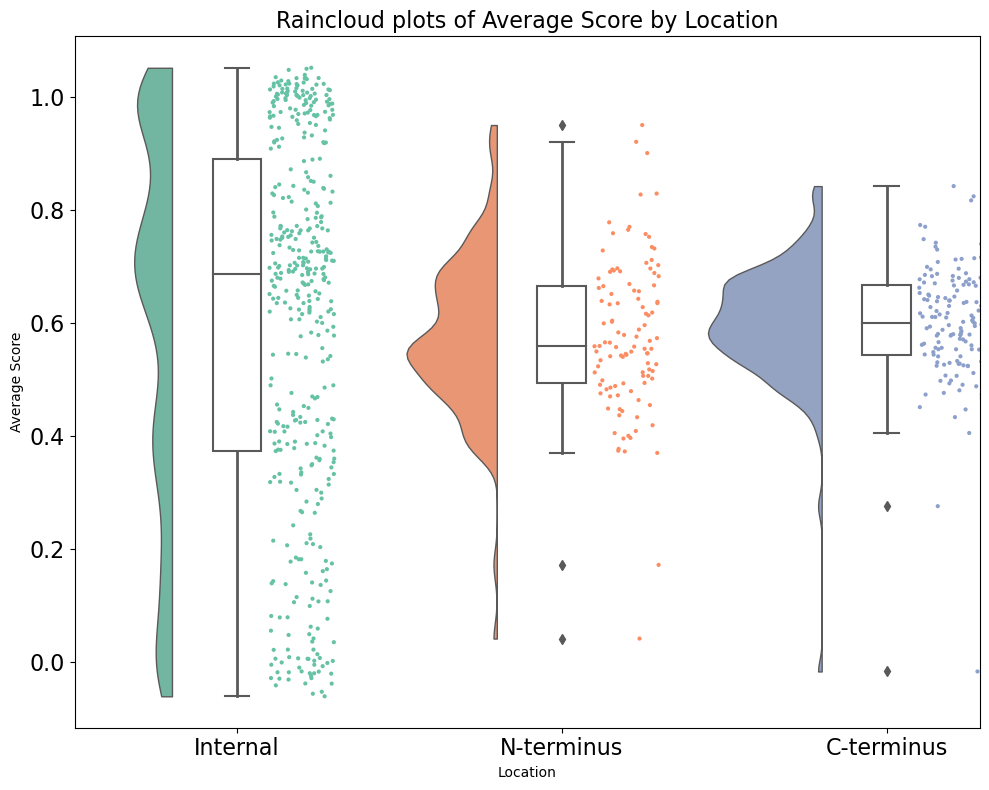

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns

# Load the data
df = pd.read_csv('degronopedia_plot_data.csv')

# Set up the figure
plt.figure(figsize=(10, 8))

# Create the raincloud plot
pt.RainCloud(x="Location", y="Average_Score", data=df, 
             width_viol=0.7, width_box=0.15, 
             orient='v', move=0.2, palette="Set2")

# Set the title and labels
plt.title('Raincloud plots of Average Score by Location', fontsize=16)
plt.xlabel('Location')
plt.ylabel('Average Score')

# Increase the font size of the tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()
plt.savefig('degronopedia_degron_scores_annotated_raincloud.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Pearson's correlation between average tile degron score and PSI of proteins with average rASA above increasing thresholds (S9)

No data points for rasa_average > 0.9
No data points for rasa_average > 1.0


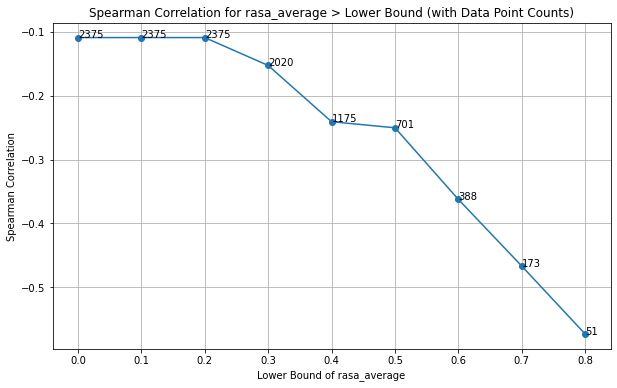

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Load the data
df1 = pd.read_csv('Voutsinos25_tile_proteome.csv')
df2 = pd.read_csv('merged_ORFome_final.csv')

# Drop rows with NaN values in relevant columns
df1 = df1.dropna(subset=['plddt_average', 'rasa_average'])

# Function to normalize and expand the 'uniprot' column in df1
def expand_uniprot_column(df):
    expanded_rows = []
    for _, row in df.iterrows():
        uniprot_ids = row['uniprot'].strip("[]").replace("'", "").split(", ")
        for uniprot_id in uniprot_ids:
            new_row = row.copy()
            new_row['uniprot'] = uniprot_id
            expanded_rows.append(new_row)
    return pd.DataFrame(expanded_rows)

# Expand df1's uniprot column
df1 = expand_uniprot_column(df1)

# Function to calculate Spearman correlation and count of points for a given lower bound of rasa_average
def calculate_spearman_and_count(data, lower_bound):
    filtered_data = data[data['rasa_average'] > lower_bound]
    if not filtered_data.empty:
        spearman_corr, _ = stats.spearmanr(filtered_data['degron_score'], filtered_data['PSI'])
        count = len(filtered_data)
        return spearman_corr, count
    else:
        return None, 0

# Check necessary columns
if 'degron_score' in df1.columns and 'uniprot' in df1.columns and 'PSI' in df2.columns:
    # Data merging and grouping
    avg_values = df1.groupby('uniprot')[['degron_score', 'plddt_average', 'rasa_average']].mean()
    psi_values = df2.groupby('uniprot')['PSI'].mean()
    
    # Merge on uniprot IDs
    merged = pd.merge(avg_values, psi_values, left_index=True, right_index=True, how='inner').dropna()

    # Initializing lists to store results
    spearman_correlations = []
    rasa_lower_bounds = []
    point_counts = []

    # Iterating over rasa lower bounds
    for i in np.arange(0, 1.1, 0.1):
        spearman_corr, count = calculate_spearman_and_count(merged, i)
        if spearman_corr is not None:
            spearman_correlations.append(spearman_corr)
            point_counts.append(count)
            rasa_lower_bounds.append(i)
        else:
            print(f"No data points for rasa_average > {i}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(rasa_lower_bounds, spearman_correlations, marker='o')
    for i, txt in enumerate(point_counts):
        plt.annotate(txt, (rasa_lower_bounds[i], spearman_correlations[i]))
    plt.xlabel('Lower Bound of rasa_average')
    plt.ylabel('Spearman Correlation')
    plt.title('Spearman Correlation for rasa_average > Lower Bound (with Data Point Counts)')
    plt.grid(True)
    plt.savefig('Spearman_vs_lower_bound_rasa_average.pdf', format='pdf')
    plt.show()
else:
    print("Necessary columns are not present in the dataframes.")

# KRTAP111 degron-rASA-pLDDT maps (S10)

Please enter the ENSG+number: ENSG00000182591


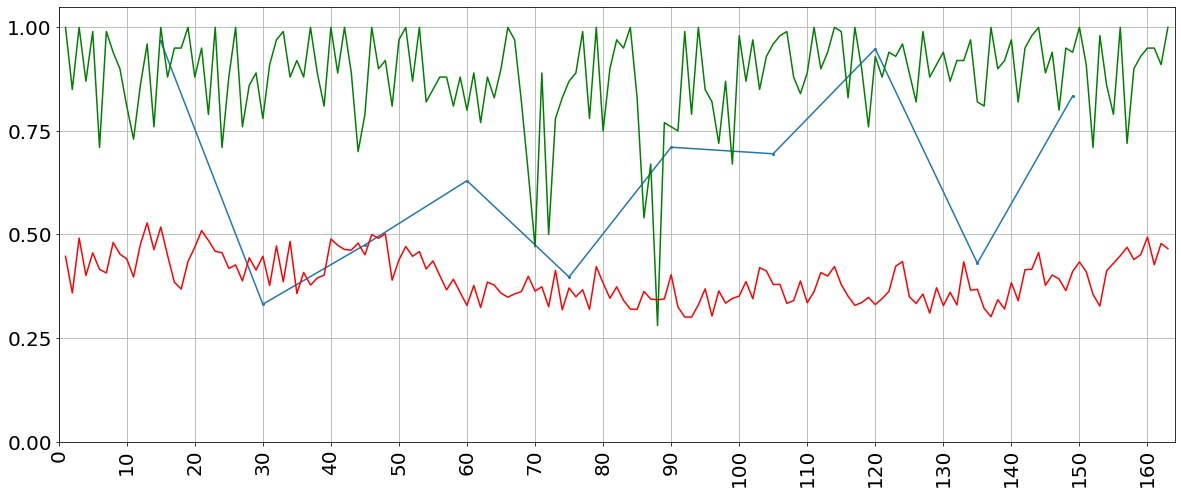

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the csv file for degrons
df = pd.read_csv('scores.csv')

# Load the unique_proteins.csv file
unique_proteins_df = pd.read_csv('genes.csv')

# Load the KRTAP111_exposure_disorder.csv file
exposure_disorder_df = pd.read_csv('KRTAP111_exposure_disorder.csv')

# Get input from user
input_name = input("Please enter the ENSG+number: ") # KRTAP111: ENSG00000182591

# Filter dataframe to get only the rows where 'name' starts with the input_name
filtered_df = df[df['name'].str.startswith(input_name + "_tile")]

# Extract 'num' from 'name' and convert it to int for proper sorting
filtered_df = filtered_df.copy()
filtered_df['num'] = filtered_df['name'].apply(lambda x: int(x.split('_tile')[1]))

# Sort the dataframe based on 'num'
filtered_df = filtered_df.sort_values(by='num')

# Drop 'dna' column
filtered_df = filtered_df.drop('dna', axis=1)

# Extract the length of the sequence for the given input_name from unique_proteins_df using the 'gene' column
seq_length = unique_proteins_df[unique_proteins_df['gene'] == input_name]['seq_aa'].str.len().iloc[0]

# Create a new column 'num_x_15' for the x-axis
filtered_df['num_x_15'] = filtered_df['num'] * 15

# Update the last x-coordinate to be L-14
filtered_df.at[filtered_df.index[-1], 'num_x_15'] = seq_length - 14

# Calculate the number of data points
num_points = len(filtered_df)

# Calculate the figure width based on the number of data points
fig_width = max(num_points / 5, 20)

# Create the plot with dynamically adjusted figure size
plt.figure(figsize=(fig_width, 8))

# Plot the dots and line
plt.plot(filtered_df['num_x_15'], filtered_df['degron_score'], 'o-', markersize=2, label='Degron score')

# Overlay green plot line for rASA
plt.plot(exposure_disorder_df['resi'], exposure_disorder_df['rASA'], 'g-', label='rASA')

# Overlay red plot line for scaled_plddt
plt.plot(exposure_disorder_df['resi'], exposure_disorder_df['scaled_plddt'], 'r-', label='scaled pLDDT')

# Set x-axis limits
x_max = filtered_df['num_x_15'].max() + 15
plt.xlim(0, x_max)

# Set x-axis ticks every 10 units
plt.xticks(range(0, int(x_max) + 1, 10), rotation=90, fontsize=20)  # Rotate x-axis tick labels vertically and set font size

plt.grid()

# Set y-axis limits and step
plt.ylim(0, 1.05)
plt.yticks([i * 0.25 for i in range(0, 5)], fontsize=20)  # Set font size for y-axis





# Save the plot as pdf
plt.savefig(input_name + '.pdf', format='pdf', dpi=300)

# Show the plot
plt.show()

## Correlation of PAP with GFP:mCherry measurements (S12)

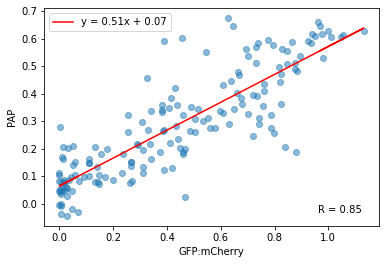

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the data
df = pd.read_csv('Validation_points.csv')

# Extract the columns
x = df['Adjusted Mean (Derived)']
y = df['PAP']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create a function for the line of best fit
def line(x):
    return slope * x + intercept

# Create the scatter plot
plt.scatter(x, y, alpha=0.5)

# Add the line of best fit
plt.plot(x, line(x), color='red', label=f'y = {slope:.2f}x + {intercept:.2f}')

# Add correlation coefficient (R value)
plt.text(0.95, 0.05, f'R = {r_value:.2f}', horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes)

# Add labels and title
plt.xlabel('GFP:mCherry')
plt.ylabel('PAP')


# Show the legend
plt.legend()

# Show the plot
plt.savefig('validation_points_v_PAP.pdf', format='pdf')
plt.show()

# Calculation of correlation significance of PAP score vs abundance scores in VAMP-seq proteins and plotting of exposed vs burried correlations

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

df_all = pd.read_csv('vamp_seq_pap_correlation.csv',
            index_col='aa')

### Calculate Pearson r and p-values

In [5]:
dict_pearsonr = {}

for prot in df_all['prot'].dropna().unique():
    dict_pearsonr[prot] = {'i': [], 'r': [], 'p': [], 'n': []}
    df_prot = df_all.query(f'prot == "{prot}"')
    for i in df_prot['central_resi']:
        x = df_prot.query(f'{i-0:d}<=central_resi<={i+0:d}')['DeltaPAP'] # DeltaPAP tile size = 30
        y = df_prot.query(f'{i-0:d}<=central_resi<={i+0:d}')['abundance_score']
        
        # Create a mask where neither x nor y is NaN or inf
        valid_mask = ~(np.isnan(x) | np.isinf(x) | np.isnan(y) | np.isinf(y))
        
        # Apply the mask to both x and y
        clean_x = x[valid_mask]
        clean_y = y[valid_mask]
        
        if len(clean_x) > 1 and len(clean_y) > 1:
            r, p = stats.pearsonr(clean_x, clean_y)
            n = len(clean_x)  # Count of data points
            dict_pearsonr[prot]['i'].append(i)
            dict_pearsonr[prot]['r'].append(r)
            dict_pearsonr[prot]['p'].append(p)
            dict_pearsonr[prot]['n'].append(n)

# Save the dictionary for later use
with open('p_values_1_pap_30.pkl', 'wb') as f:
    pickle.dump(dict_pearsonr, f)

### Load data for all the proteins

In [6]:
with open('p_values_1_pap_30.pkl', 'rb') as f:
    dict_pearsonr = pickle.load(f)

### Save CSV files

In [7]:
# Group by 'central_resi' and 'prot' and filter groups with more than one row
df_filtered = df_all.groupby(['central_resi', 'prot']).filter(lambda x: len(x) > 1)

# Step 2: Process each protein in dict_pearsonr
for prot in dict_pearsonr.keys():
    # Initialize the DataFrame 
    df = pd.DataFrame(index=dict_pearsonr[prot]['i'], columns=['-', 'r', 'p', 'rASA', 'threshold', 'n', 'Mut', 'delta_PAP', 'abundance_score', 'scaled_pLDDT'])
    
    # Fill the DataFrame
    df['n'] = dict_pearsonr[prot]['n']
    df['r'] = dict_pearsonr[prot]['r']
    df['p'] = dict_pearsonr[prot]['p']
    df['rASA'] = df_filtered.query(f'prot == "{prot}"').rASA.values
    df['threshold'] = 0.05 / len(dict_pearsonr[prot]['i'])
    df['Mut'] = df_filtered.query(f'prot == "{prot}"').variant.values
    df['delta_PAP'] = df_filtered.query(f'prot == "{prot}"').DeltaPAP.values
    df['abundance_score'] = df_filtered.query(f'prot == "{prot}"').abundance_score.values
    df['scaled_pLDDT'] = df_filtered.query(f'prot == "{prot}"').scaled_pLDDT.values
    
    # Save the DataFrame to CSV
    df.to_csv(f'complete_p_values_{prot}_1_pap_30.csv')

### Bootstrap

In [8]:
def bootstrap(a,b,n_bootstrap,subsample=False):
    # bootstrapping is used to estimate the error on cohen's d
    cohens_d = (a.mean()-b.mean()) / np.sqrt(0.5*(a.std()**2+b.std()**2))
    pvalue = stats.brunnermunzel(a,b, alternative='greater')[1]
    a_picked_size = a.size
    b_picked_size = a_picked_size if subsample else b.size
    cohen_d_b = np.empty(0)
    W_BM_b = np.empty(0)
    for _ in range(n_bootstrap):
        a_p = np.random.choice(a,size=a_picked_size)
        b_p = np.random.choice(b,size=b_picked_size)
        cohen_d_b = np.append(cohen_d_b, (a_p.mean()-b_p.mean()) / np.sqrt(0.5*(a_p.std()**2+b_p.std()**2)))
        W_BM_b = np.append(W_BM_b, stats.brunnermunzel(a_p, b_p)[0])
    if cohens_d > 0:
        pvalue_b = np.sum(W_BM_b>=0) / n_bootstrap
    else:
        pvalue_b = np.sum(W_BM_b<=0) / n_bootstrap
    return cohens_d, np.std(cohen_d_b), pvalue, pvalue_b



### Plot exposed vs burried correlations (S13)

308 28 280 308
5.919460235905468e-06 0.0 6e-06
486 36 450 486
0.0016835583667324208 0.0014 0.002
480 39 441 480
0.29543149718045575 0.2951 0.3
163 25 138 163
0.0073595741308890295 0.0062 0.007
464 116 348 464
4.146904278578875e-28 0.0 4e-28
373 78 295 373
0.00044145056647058514 0.0002 0.0004
241 31 210 241
1.1446167806620633e-06 0.0 1e-06
162 24 138 162
0.9622543186609512 0.0345 1


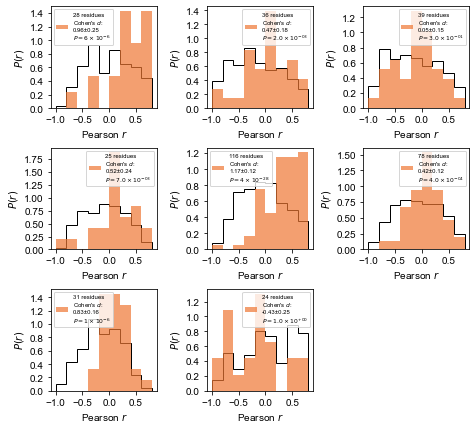

In [9]:
def format_scientific(x):
    # Check if 'e' is present in the string
    if 'e' in x:
        a = x.split('e')[0]
        b = int(x.split('e')[1])
        return a + '\\times' + '10^{'+ f'{b:d}' + '}'
    else:
        # If 'e' is not present, convert the number to scientific notation first
        number = float(x)
        return f'{number:.1e}'.replace('e', '\\times10^{') + '}'

fig, axes = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(6.6,6))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

bin_width = .2
bins = np.arange(-1, 1,bin_width)
x = bins[:-1]+bin_width/2.


for prot, ax in zip(dict_pearsonr.keys(), axes.flatten()):
    df = pd.read_csv(f'complete_p_values_{prot:s}_1_pap_30.csv')

    # Identify the unnamed column
    unnamed_col = df.columns[df.columns.str.contains('Unnamed')][0]
    
    # Find unique rows
    unique_df = df.drop_duplicates(subset=unnamed_col)

    # Apply the filtering criteria
    a = unique_df.query('rASA > 0.7').r
    b = unique_df.query('rASA <= 0.7').r
    
    # Print the sizes of the DataFrame and the filtered subsets
    print(unique_df.shape[0], a.shape[0], b.shape[0], a.shape[0] + b.shape[0])

   # Plotting
    ax.hist(b, bins, density=True, histtype='step', color='k', zorder=0)
    
    h_1 = np.histogram(a, bins=bins, density=True)[0]
    
    cohens_d, cohens_d_se, pvalue, pvalue_b = bootstrap(a, b, 10000)
    
    print(pvalue, pvalue_b, f'{pvalue:.1g}')
    
    cohens_d_str = f'{cohens_d:.2f}±{cohens_d_se:.2f}'
    pvalue_str = f'{pvalue:.1g}' if pvalue == 0 else format_scientific(f'{pvalue:.1g}')
    
    ax.bar(x, h_1, alpha=.7, width=bin_width, color='#EE7733',
           label=f'{a.shape[0]:d} residues' + "\nCohen's $d$:\n" + cohens_d_str + f'\n$P={pvalue_str}$')
    
    ax.set_xlabel('Pearson $r$')
    ax.set_ylabel('$P(r)$')
    ax.legend(frameon=True)

# Finalize the plot
axes.flatten()[-1].axis('off')
axes.flatten()[-1].axis('off')
plt.tight_layout()
plt.savefig('r_dist_0c7_1_pap_30.pdf') # The eight vamp-seq protein plots are ordered alphabetically

# ASPA tiles vs full-length abundance correlation (S15)

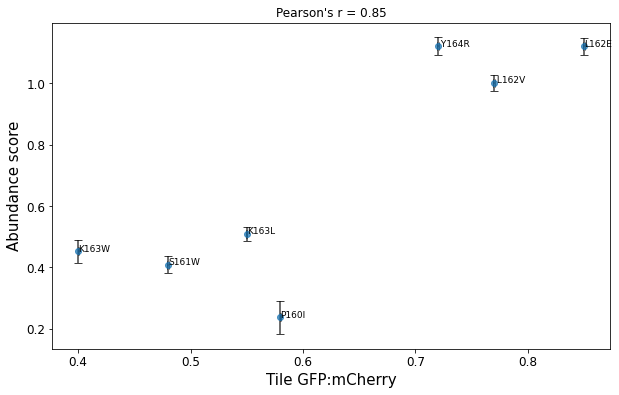

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the data
data = pd.read_csv('ASPA_tiles.csv')

# Drop rows where with NaN
data = data.dropna(subset=['C_H_mean', 'VAMP_seq_score', 'C_H_sd', 'C_H_count'])

# Calculate the standard error of the mean for 'C_H_mean'
data['C_H_sem'] = data['C_H_sd'] / data['C_H_count']**0.5

# Extract the values from the first unnamed column
labels = data.iloc[:, 0]

# Create a scatter plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(data['C_H_mean'], data['VAMP_seq_score'], xerr=data['C_H_sem'], yerr=data['VAMP_seq_sd'], fmt='o', ecolor='black', alpha=0.75, capsize=4)

# Annotate each point with the value from the first unnamed column
for i, label in enumerate(labels):
    plt.annotate(label, (data['C_H_mean'].iloc[i], data['VAMP_seq_score'].iloc[i]), fontsize=9)

# Calculate Pearson's correlation
pearson_corr, _ = stats.pearsonr(data['C_H_mean'], data['VAMP_seq_score'])
plt.title(f"Pearson's r = {pearson_corr:.2f}")
plt.xlabel('Tile GFP:mCherry', size=15)
plt.ylabel('Abundance score', size=15)

# Adjust tick label sizes
plt.tick_params(axis='both', labelsize=12)  # increase label size for both axes

# Save the plot to a PDF file
plt.savefig('scatter_plot_with_error_bars.pdf')

plt.show()

# Select relevant columns to write to a new CSV
output_data = data[['C_H_mean', 'VAMP_seq_score', 'C_H_sem', 'VAMP_seq_sd']]
output_data.to_csv('plotted_values_with_sem.csv', index=False)

# Correlation of DeltaPAP to abundance score of ASPA window of the 5 positions around position 258 (S16)

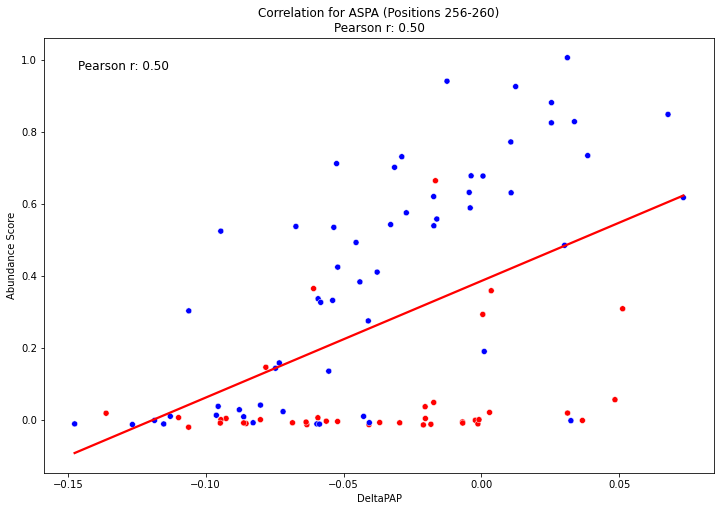

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

def plot_correlation_with_trendline(data, id_human, start_position, end_position, x_range, y_range, font_size=8):
    """
    Plot a scatter plot with a trend line for a specified protein and position range.
    Highlights points where 'variant' starts with 'P' in red.
    """
    # Filter data for the specified protein and position range
    subset = data[(data['ID'] == id_human) & 
                  (data['central_resi'] >= start_position) & 
                  (data['central_resi'] <= end_position)]

    # Keep only rows where 'DeltaPAP' and 'abundance_score' are not NaN or inf
    subset = subset[['DeltaPAP', 'abundance_score', 'variant']].replace([np.inf, -np.inf], np.nan).dropna()

    # Check if there is enough data
    if subset.shape[0] < 2:
        print(f"Not enough data for {id_human} in the specified range.")
        return

    # Calculate Pearson correlation
    r, _ = pearsonr(subset['DeltaPAP'], subset['abundance_score'])

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='DeltaPAP', y='abundance_score', data=subset, hue=subset['variant'].str.startswith('P'),
                    palette={True: 'red', False: 'blue'}, legend=False)

    sns.regplot(x='DeltaPAP', y='abundance_score', data=subset, scatter=False, color='red', ci=None)

    plt.title(f'Correlation for {id_human} (Positions {start_position}-{end_position})\nPearson r: {r:.2f}')
    plt.xlabel('DeltaPAP')
    plt.ylabel('Abundance Score')

    # Add Pearson correlation coefficient to the plot
    plt.text(0.05, 0.95, f'Pearson r: {r:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    # Save the plot as a PDF file
    plt.savefig(f'correlation_plot_{id_human}_{start_position}_{end_position}.pdf', format='pdf')

    plt.show()



x_range = (-1, 1)  
y_range = (-1, 2)  

# Load data
file_path = 'vamp_seq_pap_correlation.csv'  
data = pd.read_csv(file_path)


id_human_to_plot = 'ASPA'  
start_position = 256       
end_position = 260         

plot_correlation_with_trendline(data, id_human_to_plot, start_position, end_position, x_range, y_range)
